# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print( 'Train data shape: ', X_train.shape)
print( 'Train labels shape: ', y_train.shape)
print( 'Validation data shape: ', X_val.shape)
print( 'Validation labels shape: ', y_val.shape)
print( 'Test data shape: ', X_test.shape)
print( 'Test labels shape: ', y_test.shape)

Train data shape:  (3073, 49000)
Train labels shape:  (49000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive, softmax_loss_vectorized
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print( 'loss: %f' % loss)
print( 'sanity check: %f' % (-np.log(0.1)))

loss: 2.340258
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.981076 analytic: 1.981076, relative error: 1.461026e-08
numerical: 1.390271 analytic: 1.390271, relative error: 2.496657e-08
numerical: -0.635083 analytic: -0.635083, relative error: 1.184079e-07
numerical: -0.864397 analytic: -0.864397, relative error: 2.727239e-08
numerical: 0.818801 analytic: 0.818801, relative error: 1.491377e-08
numerical: 1.373070 analytic: 1.373070, relative error: 7.185338e-09
numerical: -0.662988 analytic: -0.662988, relative error: 4.466755e-08
numerical: 0.415578 analytic: 0.415578, relative error: 1.091772e-07
numerical: -2.934708 analytic: -2.934708, relative error: 4.484113e-11
numerical: 0.863196 analytic: 0.863196, relative error: 8.703629e-08


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_vectorized(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_vectorized(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -3.957842 analytic: -3.957842, relative error: 1.252003e-08
numerical: 0.218653 analytic: 0.218653, relative error: 6.035017e-08
numerical: -5.164249 analytic: -5.164249, relative error: 6.516191e-09
numerical: 0.354666 analytic: 0.354666, relative error: 1.744442e-08
numerical: 1.119713 analytic: 1.119713, relative error: 3.722823e-08
numerical: 3.644176 analytic: 3.644176, relative error: 1.064213e-08
numerical: 3.993082 analytic: 3.993082, relative error: 7.254485e-09
numerical: -5.430327 analytic: -5.430327, relative error: 4.193428e-09
numerical: 0.112361 analytic: 0.112361, relative error: 3.155058e-07
numerical: -1.559819 analytic: -1.559819, relative error: 2.015316e-08


In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print( 'naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print( 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print( 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print( 'Gradient difference: %f' % grad_difference)

naive loss: 2.340258e+00 computed in 6.613672s
vectorized loss: 2.340258e+00 computed in 0.387274s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
#Test Train the softmax classifier
from cs231n.classifiers import Softmax

softmax = Softmax()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4, num_iters=5000, verbose=True)

iteration 0 / 5000: loss 776.338453
iteration 100 / 5000: loss 284.982179
iteration 200 / 5000: loss 105.478227
iteration 300 / 5000: loss 39.978714
iteration 400 / 5000: loss 15.943003
iteration 500 / 5000: loss 7.144821
iteration 600 / 5000: loss 3.943755
iteration 700 / 5000: loss 2.759077
iteration 800 / 5000: loss 2.370629
iteration 900 / 5000: loss 2.210004
iteration 1000 / 5000: loss 2.101182
iteration 1100 / 5000: loss 2.098887
iteration 1200 / 5000: loss 2.064567
iteration 1300 / 5000: loss 2.152261
iteration 1400 / 5000: loss 2.035803
iteration 1500 / 5000: loss 2.083781
iteration 1600 / 5000: loss 2.076320
iteration 1700 / 5000: loss 2.102622
iteration 1800 / 5000: loss 2.012783
iteration 1900 / 5000: loss 2.062117
iteration 2000 / 5000: loss 2.035951
iteration 2100 / 5000: loss 2.077362
iteration 2200 / 5000: loss 2.143536
iteration 2300 / 5000: loss 2.087078
iteration 2400 / 5000: loss 2.038925
iteration 2500 / 5000: loss 2.014568
iteration 2600 / 5000: loss 2.149670
itera

training accuracy: 0.332082
validation accuracy: 0.342000


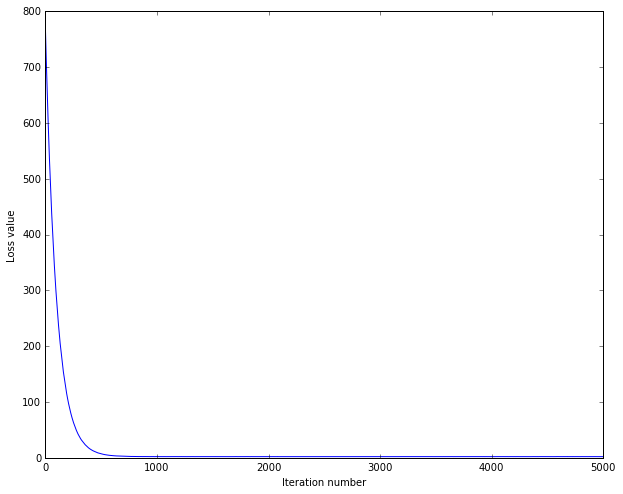

In [8]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

y_train_pred = softmax.predict(X_train)
print( 'training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print( 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [9]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.logspace(-10, -6, 5)
#[1e-7, 5e-7]
regularization_strengths = np.logspace(2, 5, 5)
#[5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iterations = 3000

import copy

for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=iterations)
        
        y_train_pred = softmax.predict(X_train)
        y_val_pred   = softmax.predict(X_val)
        
        accuracy_train = np.mean(y_train == y_train_pred)
        accuracy_valid = np.mean(y_val   == y_val_pred)
        
        results[(lr,rs)] = accuracy_train, accuracy_valid
        print('finished learning rate = ',lr, '\t regularization strength = ',rs)
        
        if best_val < accuracy_valid:
            best_val = accuracy_valid
            best_softmax = copy.deepcopy(softmax)
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print( 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print( 'best validation accuracy achieved during cross-validation: %f' % best_val)

finished learning rate =  1e-10 	 regularization strength =  100.0
finished learning rate =  1e-10 	 regularization strength =  562.34132519
finished learning rate =  1e-10 	 regularization strength =  3162.27766017
finished learning rate =  1e-10 	 regularization strength =  17782.7941004
finished learning rate =  1e-10 	 regularization strength =  100000.0
finished learning rate =  1e-09 	 regularization strength =  100.0
finished learning rate =  1e-09 	 regularization strength =  562.34132519
finished learning rate =  1e-09 	 regularization strength =  3162.27766017
finished learning rate =  1e-09 	 regularization strength =  17782.7941004
finished learning rate =  1e-09 	 regularization strength =  100000.0
finished learning rate =  1e-08 	 regularization strength =  100.0
finished learning rate =  1e-08 	 regularization strength =  562.34132519
finished learning rate =  1e-08 	 regularization strength =  3162.27766017
finished learning rate =  1e-08 	 regularization strength =  1

In [10]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print( 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.386000


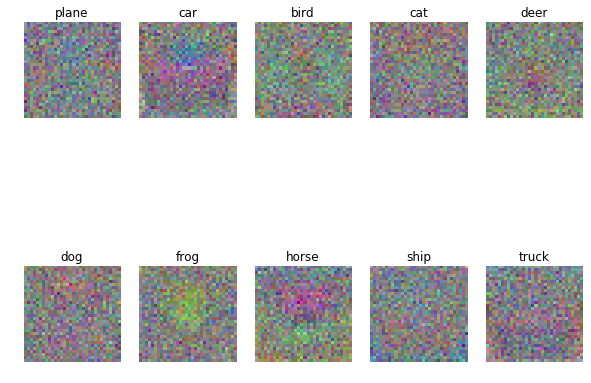

In [11]:
# Visualize the learned weights for each class
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])